# Benchmark Data Set

In this notebook, we explain how we create the benchmark testset for comparing different architectures and approaches. We will create two data sets consisting of 10.000 extended Gaussian sources with varying sampling masks. One of them with additional noise corruption on the images, the other one without.

* Fourier
* Amp_Phase
* Interpolation

In [2]:
import toml
from radionets.simulations.utils import read_config, check_outpath, adjust_outpath, add_noise
from radionets.simulations.gaussians import create_grid, create_ext_gauss_bundle
from radionets.simulations.simulate import sample_fft_images
from radionets.dl_framework.data import save_fft_pair
import numpy as np
import h5py
from tqdm import tqdm
from pathlib import Path
import re

### Configuration

In [11]:
config = toml.load("./.rc/benchmark/sim_benchmark.toml")
sim_conf = read_config(config)

# specify data_path
sim_conf["data_path"] = "../../noise/benchmark_data"

sim_fft, sim_sampled = check_outpath(
    sim_conf["data_path"],
    data_format=config["paths"]["data_format"],
    quiet=config["mode"]["quiet"],
)

Create fft_images from gaussian data set! 

Adding extended gaussian sources.


In [ ]:
noise_level = 30

In [13]:
sim_conf['bundles_test'] = 20
sim_conf['bundle_size'] = 500

### Start Simulation

In [14]:
data_path=sim_conf["data_path"]
option="test"
num_bundles=sim_conf["bundles_test"]
bundle_size=sim_conf["bundle_size"]
img_size=sim_conf["img_size"]
num_comp_ext=sim_conf["num_components"]
num_pointlike=sim_conf["num_pointlike_gaussians"]
num_pointsources=sim_conf["num_pointsources"]
noise=sim_conf["noise"]
source_list=sim_conf["source_list"]

In [15]:
np.random.seed(1337)

In [16]:
# create source images
for i in tqdm(range(num_bundles)):
    grid = create_grid(img_size, bundle_size)
    ext_gaussian = 0
    pointlike = 0
    pointsource = 0
    list_sources = 0

    if num_comp_ext is not None:
        ext_gaussian = create_ext_gauss_bundle(grid)
    if num_pointlike is not None:
        pointlike = create_gauss(
            grid[:, 0], bundle_size, num_pointlike, True, source_list
        )
    if num_pointsources is not None:
        pointsource = gauss_pointsources(grid[:, 0], bundle_size, num_pointsources)
    if source_list:
        list_sources = pointlike[1]
        pointlike = pointlike[0]

    bundle = ext_gaussian + pointlike + pointsource
    images = bundle.copy()

    path = adjust_outpath(data_path, "/source_" + option)

    with h5py.File(path, "w") as hf:
        hf.create_dataset("sources", data=bundle)

100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


In [17]:
# use source images and create fft versions without noise

# get source paths
source_path = Path(sim_conf["data_path"])
s_paths = np.array([x for x in source_path.iterdir()])
s_paths = [
    path for path in s_paths if re.findall(f"source_test", path.name)
]

# create and save fft without noise
for p in s_paths:
    f = h5py.File(p, "r")
    s = np.array(f["sources"])
    images = s.copy()
    bundle_fft = np.array([np.fft.fftshift(np.fft.fft2(img)) for img in images])
    out = p.parent/"clean"/p.name.replace("source", "fft")
    out.parent.mkdir(exist_ok=True)
    save_fft_pair(out, bundle_fft, s)
    f.close()

# create and save fft with noise
for p in s_paths:
    f = h5py.File(p, "r")
    s = np.array(f["sources"])
    images = s.copy()
    images = add_noise(images, noise_level)
    bundle_fft = np.array([np.fft.fftshift(np.fft.fft2(img)) for img in images])
    out = p.parent/"noise"/p.name.replace("source", "fft")
    out.parent.mkdir(exist_ok=True)
    save_fft_pair(out, bundle_fft, s)
    f.close()

### Sampling Frequencies

In [8]:
sim_conf["data_path"] = "../../noise/benchmark_data/clean/"
sample_fft_images(sim_conf)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


 Sampling train data set.


 No train data set fft images available.


 Sampling valid data set.


 No valid data set fft images available.


 Sampling test data set.



100%|██████████| 20/20 [06:34<00:00, 19.73s/it]


In [18]:
sim_conf["data_path"] = "../../noise/benchmark_data/noise/"
sample_fft_images(sim_conf)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]


 Sampling train data set.


 No train data set fft images available.


 Sampling valid data set.


 No valid data set fft images available.


 Sampling test data set.



100%|██████████| 10/10 [03:14<00:00, 19.42s/it]


In [10]:
sim_conf

{'data_path': '../../noise/benchmark_data/noise/',
 'data_format': 'h5',
 'type': 'gaussians',
 'num_pointsources': None,
 'num_pointlike_gaussians': None,
 'num_components': [4, 10],
 'bundles_train': 0,
 'bundles_valid': 0,
 'bundles_test': 20,
 'bundle_size': 500,
 'img_size': 63,
 'noise': False,
 'amp_phase': True,
 'real_imag': False,
 'source_list': False,
 'antenna_config': 'vlba',
 'specific_mask': False,
 'lon': -80,
 'lat': 50,
 'steps': 50,
 'fourier': True,
 'compressed': False,
 'keep_fft_files': True,
 'interpolation': True}

In [11]:
import matplotlib.pyplot as plt

In [12]:
file = h5py.File("../../noise/benchmark_data/noise/samp_test1.h5", mode="r")

In [13]:
x = file["x"]
y = file["y"]
x.shape

(500, 2, 63, 63)

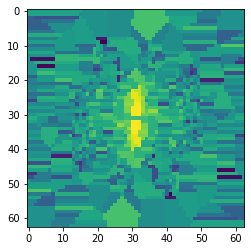

In [14]:
plt.imshow(np.abs(x[9][0]))

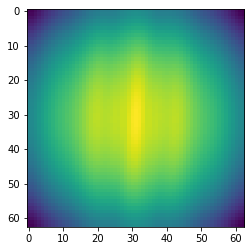

In [15]:
plt.imshow(np.abs(y[9][0]))